Constantes: tamanho do Mock e instância do Faker


In [1]:
from faker import Faker
USER_COUNT = 237517
fake = Faker()

# Funções usadas ao longo do Notebook

Gerar dia válido dentro de um determinado mês. Prioriza primeiros dias.

In [2]:
import numpy as np
import calendar
from scipy.stats import expon

def generate_days(
        month: tuple[int, int],
        size: int,
        start_day: int=1
    ) -> np.ndarray | None:
    _, last_day = calendar.monthrange(*month)
    if start_day == last_day:
        return np.full((size,), start_day)
    elif start_day > last_day:
        return None
    available_days = np.arange(start=start_day, stop=last_day + 1)
    weights = np.copy(available_days)
    weights = weights / np.sum(weights)
    weights = expon.pdf(weights)
    weights = weights / np.sum(weights)
    return np.random.choice(available_days, size=size, p=weights)

# Dados de Usuário


Iremos gerar um DataFrame Pandas para conter informações de usuário, assim como o endereço do mesmo.


In [3]:
import pandas as pd

users = pd.DataFrame({
    'id': [fake.uuid4() for _ in range(USER_COUNT)],
    'created_at': None,
    'birthday': None,
    'city': None,
    'state': None,
    'country': None
})
display(users)

,id,created_at,birthday,city,state,country
0,c3bd6b03-bd5d-45ad-85d0-bc4d642ea2a0,None,None,None,None,None
1,31ba074c-c911-42f6-b8e2-e2b75a5b867e,None,None,None,None,None
2,d01b346a-1c67-4349-860e-6e0f986dd9ed,None,None,None,None,None
3,42291a73-4ab9-4a0d-86bb-47bfa057ecd0,None,None,None,None,None
4,6b4f8a58-f2d3-43d1-8588-c0478e225ba8,None,None,None,None,None
...,...,...,...,...,...,...
237512,ac967d70-1b15-4f44-996b-6ebcd3b34f83,None,None,None,None,None
237513,302e3c3c-1419-461d-98a3-5e4f8d0fb03d,None,None,None,None,None
237514,0f8e9597-79e6-4e8b-bc5a-a5aa35ac27ed,None,None,None,None,None
237515,c67a3700-f78c-4bbb-aa46-1f783e3cb555,None,None,None,None,None


Gerando _created_at_ (omitindo _updated_at_ pois ele não aparece em nenhum lugar do relatório)


Utilizando distribuição ponderada, priorizando os meses 2, 3 e 4.


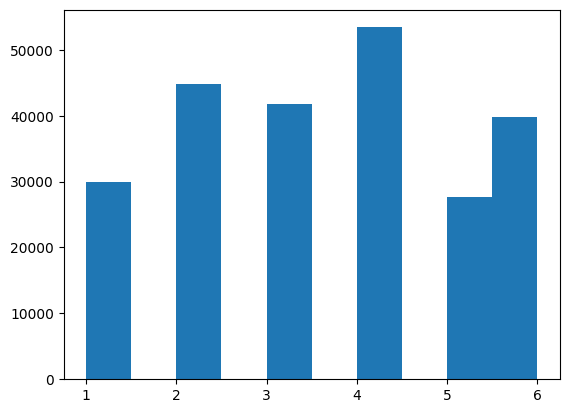

In [5]:
import numpy as np
from matplotlib import pyplot as plt

available_months = np.array([1, 2, 3, 4, 5, 6])
weights_months = np.array([1/6, 1/5, 1/5, 1/4, 1/7, 1/5])
weights_months = weights_months + \
    np.random.normal(0, 0.0125, size=weights_months.shape)
weights_months = weights_months / np.sum(weights_months)
months = np.random.choice(available_months, p=weights_months, size=USER_COUNT)
month_counts = np.bincount(months)[1:]
accumulated_month_counts = np.cumsum(month_counts)
plt.hist(months)
plt.show()

Utilizando distribuição ponderada, priorizando dias iniciais do mês


Horas não são aleatórias: priorizar horários de pico


In [6]:
import numpy as np
from scipy.stats import skewnorm


def gen_random_minutes(size):
    minutes = skewnorm.rvs(a=-0.5, loc=960, scale=240, size=size)
    while True:
        minutes = np.round(minutes, 0).astype(int)
        minutes_outside_interval = np.argwhere(
            (minutes < 0) | (minutes >= 1440)).flatten()
        if (minutes_outside_interval.size == 0):
            break
        minutes[minutes_outside_interval] = skewnorm.rvs(
            a=-0.5, loc=960, scale=240, size=len(minutes_outside_interval))
    return minutes


minutes = gen_random_minutes(USER_COUNT)
hours = minutes // 60
minutes = minutes % 60

Adicionando created_at


In [7]:
from datetime import datetime
import numpy as np

current_idx = 0
for month, user_count_month in zip(available_months, month_counts):
    random_days = generate_days((2023, month), size=user_count_month)
    c_at_array = np.empty((user_count_month,), dtype=object)
    for i in range(user_count_month):
        c_at_array[i] = datetime(
            2023,
            month,
            random_days[i],
            hours[current_idx + i],
            minutes[current_idx + i],
            np.random.randint(0, 60)
        ).isoformat()
    pd_idx = users.index[current_idx:current_idx+user_count_month]
    users.loc[pd_idx, 'created_at'] = c_at_array
    current_idx += user_count_month

Gerando datas de nascimento


Ano será escolhido através de uma distribuição que prioriza fim dos anos 90 e anos 2000


Ano mínimo: 1965
Ano máximo: 2005


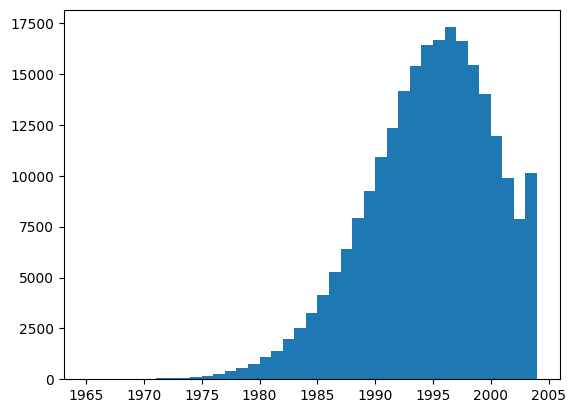

In [8]:
from matplotlib import pyplot as plt
from scipy.stats import skewnorm

alpha = -1.7
loc = 2000
scale = 8
random_years = skewnorm.rvs(a=alpha, loc=loc, scale=scale, size=USER_COUNT)
while True:
    random_years = np.round(random_years, 0).astype(int)
    outside_interval = np.argwhere(random_years > 2005).flatten()
    if (outside_interval.size == 0):
        break
    random_years[outside_interval] = skewnorm.rvs(
        a=alpha, loc=loc, scale=scale, size=len(outside_interval))
# Count the number of users created in each year
# Year is x axis, count is y axis
minimum_year = np.min(random_years)
maximum_year = np.max(random_years)
print(f'Ano mínimo: {minimum_year}')
print(f'Ano máximo: {maximum_year}')
plt.hist(random_years, bins=range(minimum_year, maximum_year))
plt.show()

Mês e dia são completamente randômicos, utiliza distribuição uniforme


In [9]:
random_dates_with_year = np.empty((USER_COUNT,), dtype=object)
for i in range(USER_COUNT):
    year = random_years[i]
    lower_bound = datetime(year, 1, 1)
    upper_bound = datetime(year, 12, 31)
    random_date = fake.date_between(
        start_date=lower_bound, end_date=upper_bound).strftime('%Y-%m-%d')
    random_dates_with_year[i] = random_date
users['birthday'] = random_dates_with_year

Ordenando DataFrame de forma que created_at seja crescente


In [10]:
users = users.sort_values(by='created_at')
users = users.reset_index(drop=True)
display(users)

,id,created_at,birthday,city,state,country
0,178e51d0-bc9e-4cae-bcf1-5182865c6469,2023-01-01T03:11:40,1993-02-06,None,None,None
1,f1369c9b-6c81-4304-9cff-029b31bbc587,2023-01-01T03:13:42,1993-08-13,None,None,None
2,7243dc08-9c7f-4494-bc7c-738bccc2a76e,2023-01-01T04:08:49,1988-06-02,None,None,None
3,07412aea-a8f2-4dc9-91ea-ba7a93869295,2023-01-01T04:56:48,1996-01-31,None,None,None
4,aea2418e-8e7b-4305-bb6a-f52aefd204d2,2023-01-01T05:01:59,1996-05-26,None,None,None
...,...,...,...,...,...,...
237512,0f775efa-6ea3-4e3b-938b-412c88f84aa2,2023-06-30T23:30:04,1990-06-03,None,None,None
237513,d1182d35-c0b8-4f72-a907-1285ba22e4ab,2023-06-30T23:32:42,2002-06-27,None,None,None
237514,3026160b-de06-4b40-80a1-5b6d016615a8,2023-06-30T23:39:03,1993-05-15,None,None,None
237515,11ea829d-d49f-4a60-b446-9924f6ccdc8a,2023-06-30T23:40:25,2000-03-19,None,None,None


# Endereços


Queremos mudar a distribuição de endereços com base na data do onboarding. Portanto, é interessante antes criar uma função que recebe alguns parâmetros, como:

- Importância da população para decidir a cidade
- Presença de cidades fora do Brasil?
- etc


## Cidades do Brasil

Utilizando .csv de municipios contidos [aqui](http://blog.mds.gov.br/redesuas/wp-content/uploads/2018/06/Lista_Munic%C3%ADpios_com_IBGE_Brasil_Versao_CSV.csv)


In [11]:
# Renomeie o CSV
municipios = pd.read_csv('municipios.csv', sep=';')
# Ignorando duas colunas
municipios = municipios.drop(columns=[
    'ConcatUF+Mun',
    'Unnamed: 9']).sort_values(by=['População 2010'], ascending=False)
# Ignorando munícipios sem informação de população
municipios = municipios.dropna(subset=['População 2010'])
municipios = municipios.reset_index(drop=True)
display(municipios.head(5))
# Transformando Presidente Prudente em uma cidade com 2M de habitantes
# Só pelo lulz
municipios.loc[
    municipios['Município'] == 'Presidente Prudente',
    'População 2010'
  ] = 2000000
display(municipios[municipios['Município'] == 'Presidente Prudente'])

,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
0,355030,3550308,SP,São Paulo,Região Sudeste,11253503.0,Metrópole,Capital
1,330455,3304557,RJ,Rio de Janeiro,Região Sudeste,6320446.0,Metrópole,Capital
2,292740,2927408,BA,Salvador,Região Nordeste,2675656.0,Metrópole,Capital
3,530010,5300108,DF,Brasília,Região Centro-Oeste,2570160.0,Metrópole,Capital
4,230440,2304400,CE,Fortaleza,Região Nordeste,2452185.0,Metrópole,Capital


,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
125,354140,3541406,SP,Presidente Prudente,Região Sudeste,2000000.0,Grande,NaN


## Cidades fora do Brasil

Utilizando csv que pode ser encontrado [aqui](https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.76.zip)


In [12]:
world_cities = pd.read_csv('worldcities.csv')
# Ignorando cidades sem dados populacionais
world_cities = world_cities.dropna(subset=['population'])
# Ignorando cidades brasileiras
world_cities = world_cities[world_cities['country'] != 'Brazil']
world_cities = world_cities.reset_index(drop=True)
display(world_cities.head(5))

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629


Países da América Latina


In [13]:
latin_america_countries = [
    'Argentina',
    'Bolivia',
    'Chile',
    'Colombia',
    'Ecuador',
    'Paraguay',
    'Peru',
    'Uruguay'
]

Finalmente, preparando a função


In [14]:
def generate_random_cities(size, population_importance=1.6, non_brazilian_percent=0.0, latin_america_importance=10.0):
    brazilian_percent = 1.0 - non_brazilian_percent
    brazilian_size = int(size * brazilian_percent)
    non_brazilian_size = size - brazilian_size
    cities = pd.DataFrame(columns=['city', 'state', 'country'])
    # Cidades brasileiras
    brazilian_cities = pd.DataFrame(columns=['city', 'state', 'country'])
    brazilian_population_power = np.power(
        municipios['População 2010'], population_importance)
    brazilian_population_weights = brazilian_population_power / \
        np.sum(brazilian_population_power)
    brazilian_cities_idx = np.random.choice(
        municipios.index, p=brazilian_population_weights, size=brazilian_size)
    brazilian_cities['city'] = municipios.loc[brazilian_cities_idx,
                                              'Município'].values
    brazilian_cities['state'] = municipios.loc[brazilian_cities_idx, 'UF'].values
    brazilian_cities['country'] = 'Brazil'
    # Cidades não brasileiras
    non_brazilian_cities = pd.DataFrame(columns=['city', 'state', 'country'])
    non_brazilian_population_power = np.power(
        world_cities['population'], population_importance)
    latin_american_countries_idx = world_cities['country'].isin(
        latin_america_countries)
    non_brazilian_population_power[latin_american_countries_idx] = np.power(
        non_brazilian_population_power[latin_american_countries_idx], latin_america_importance)
    non_brazilian_population_weights = non_brazilian_population_power / \
        np.sum(non_brazilian_population_power)
    non_brazilian_cities_idx = np.random.choice(
        world_cities.index, p=non_brazilian_population_weights, size=non_brazilian_size)
    non_brazilian_cities['city'] = world_cities.loc[non_brazilian_cities_idx, 'city'].values
    non_brazilian_cities['state'] = ''
    non_brazilian_cities['country'] = world_cities.loc[non_brazilian_cities_idx, 'country'].values
    # Concatenando
    cities = pd.concat([brazilian_cities, non_brazilian_cities])
    cities = cities.reset_index(drop=True)
    return cities

Primeiros 2 meses: focar em capitais do Brasil


In [15]:
start_idx = 0
end_idx = accumulated_month_counts[1]
count = end_idx - start_idx
cities = generate_random_cities(count, population_importance=2.5)
users.loc[users.index[start_idx: end_idx], [
    'city', 'state', 'country']] = cities.values

2 próximos meses: cidades brasileiras com menor população


In [16]:
start_idx = accumulated_month_counts[1]
end_idx = accumulated_month_counts[3]
count = end_idx - start_idx
cities = generate_random_cities(count, population_importance=1.5)
users.loc[users.index[start_idx: end_idx], [
    'city', 'state', 'country']] = cities.values

2 últimos meses: cidades no exterior


In [17]:
start_idx = accumulated_month_counts[3]
end_idx = accumulated_month_counts[-1]
count = end_idx - start_idx
cities = generate_random_cities(
    count, population_importance=1.0, non_brazilian_percent=0.15, latin_america_importance=4.0)
users.loc[users.index[start_idx: end_idx], [
    'city', 'state', 'country']] = cities.values

Resultado final


In [18]:
display(users['country'].value_counts())
display(users['state'].value_counts())
display(users['city'].value_counts())

country
Brazil       227386
Argentina      8161
Peru           1221
Colombia        454
Chile           265
Bolivia          21
Ecuador           8
Uruguay           1
Name: count, dtype: int64

state
SP    104227
RJ     32160
MG     13122
BA     10584
       10131
CE      7256
PR      7112
RS      6479
PE      5975
PA      4947
DF      4873
GO      3952
MA      3627
AM      3518
SC      3327
PB      2051
ES      2014
AL      1868
RN      1827
PI      1797
MT      1562
MS      1475
SE      1132
RO       757
TO       652
AP       429
AC       420
RR       243
Name: count, dtype: int64

city
São Paulo         81528
Rio de Janeiro    25115
Buenos Aires       8167
Salvador           5169
Brasília           4873
                  ...  
Morro Reuter          1
Vereda                1
Pequeri               1
Pavussu               1
Montevideo            1
Name: count, Length: 4789, dtype: int64

# Salvando dados de usuário em CSV


In [19]:
users.to_csv('users.csv', index=False)

# Transferências


## Função que gera transferências com determinada distribuição de valores e horas


In [20]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import calendar


def generate_transfers(
        user_ids,
        transfer_quantity,
        loc=50,
        scale=25,
        num_outliers=0
    ):
    transfers = pd.DataFrame(
        columns=[
            'id_from',
            'id_to',
            'hour',
            'minute',
            'scheduled_date',
            'value',
            'status'
        ]
    )
    ids_from, ids_to = user_ids
    total_size = transfer_quantity
    values = np.random.normal(
        loc=loc,
        scale=scale,
        size=total_size - num_outliers
    )
    values = np.append(values, np.random.normal(
            loc=3000,
            scale=1000,
            size=num_outliers
        )
    )
    values = np.abs(values)
    values = np.round(values, 2)
    status = np.random.choice(
        ['FAILED', 'DONE', 'SCHEDULED'],
        p=[0.001, 0.6, 0.399], size=total_size)
    # Chose random ids
    transfers_ids_from = np.random.choice(ids_from, size=total_size)
    transfers_ids_to = np.random.choice(ids_to, size=total_size)
    transfers['id_from'] = transfers_ids_from
    transfers['id_to'] = transfers_ids_to
    transfers['value'] = values
    transfers['status'] = status
    # Horário das transferências
    minutes = gen_random_minutes(total_size)
    hours = minutes // 60
    minutes = minutes % 60
    transfers['hour'] = hours
    transfers['minute'] = minutes
    return transfers


def decide_transfers_dates(transfers: pd.DataFrame):
    users_created_at = users[['id', 'created_at']]
    transfer_with_user_info = pd\
        .merge(
            transfers,
            users_created_at,
            left_on='id_from',
            right_on='id',
            how='inner')\
        .drop('id', axis=1)
    transfer_with_user_info = pd\
        .merge(
            transfer_with_user_info,
            users_created_at,
            left_on='id_to',
            right_on='id',
            how='inner')\
        .drop('id', axis=1)
    transfer_with_user_info['lower_bound'] = transfer_with_user_info\
        .apply(
            lambda row: max(
                row['created_at_x'],
                row['created_at_y']
            ),
            axis=1
    )
    transfer_with_user_info = transfer_with_user_info\
        .drop(
            ['created_at_x', 'created_at_y'],
            axis=1
        )
    def gen_month_day(hour, minute, lower_bound):
        lower_bound = datetime.fromisoformat(lower_bound)
        month = np.random.randint(lower_bound.month, 8)
        _, last_day = calendar.monthrange(2023, month)
        if month == 7:
            day = 1
        else:
            if month > lower_bound.month:
                start_day = 1
            else:
                start_day = lower_bound.day
            date = datetime(2023, month, start_day, int(hour), int(minute))
            if (date <= lower_bound):
                start_day += 1
                if start_day > last_day:
                    month += 1
                    start_day = 1
            day = generate_days((2023, month), 1, start_day=start_day)[0]
        date = datetime(2023, month, day, hour, minute)
        if (date > lower_bound):
            return (day, month)
    gen_month_day_vectorized = np.vectorize(gen_month_day)
    temp = np.array([
        transfer_with_user_info['hour'],
        transfer_with_user_info['minute'],
        transfer_with_user_info['lower_bound']
    ])
    day, month = gen_month_day_vectorized(*temp)
    temp_t = temp.transpose()
    temp = np.array([
        month,
        day,
        temp_t[:, 0],
        temp_t[:, 1]
    ])
    def gen_date_time(month, day, hour, minute):
        return datetime(
            2023,
            month,
            day,
            hour,
            minute,
            np.random.randint(0, 60)).isoformat()
    gen_date_time_vectorized = np.vectorize(gen_date_time)
    date_times = gen_date_time_vectorized(*temp)
    new_transfers = transfers.copy()
    new_transfers.drop(['hour', 'minute'], axis=1, inplace=True)
    new_transfers['time'] = date_times
    return new_transfers

In [21]:
def age_from_birthday(birthday_str):
    birthday = datetime.fromisoformat(birthday_str)
    difference = datetime.now() - birthday
    age = difference.days // 365
    return age


users['age'] = users['birthday'].apply(age_from_birthday)
display(users)

,id,created_at,birthday,city,state,country,age
0,178e51d0-bc9e-4cae-bcf1-5182865c6469,2023-01-01T03:11:40,1993-02-06,São Paulo,SP,Brazil,30
1,f1369c9b-6c81-4304-9cff-029b31bbc587,2023-01-01T03:13:42,1993-08-13,São Paulo,SP,Brazil,29
2,7243dc08-9c7f-4494-bc7c-738bccc2a76e,2023-01-01T04:08:49,1988-06-02,Rio de Janeiro,RJ,Brazil,35
3,07412aea-a8f2-4dc9-91ea-ba7a93869295,2023-01-01T04:56:48,1996-01-31,São Paulo,SP,Brazil,27
4,aea2418e-8e7b-4305-bb6a-f52aefd204d2,2023-01-01T05:01:59,1996-05-26,Brasília,DF,Brazil,27
...,...,...,...,...,...,...,...
237512,0f775efa-6ea3-4e3b-938b-412c88f84aa2,2023-06-30T23:30:04,1990-06-03,Buenos Aires,,Argentina,33
237513,d1182d35-c0b8-4f72-a907-1285ba22e4ab,2023-06-30T23:32:42,2002-06-27,Buenos Aires,,Argentina,21
237514,3026160b-de06-4b40-80a1-5b6d016615a8,2023-06-30T23:39:03,1993-05-15,Buenos Aires,,Argentina,30
237515,11ea829d-d49f-4a60-b446-9924f6ccdc8a,2023-06-30T23:40:25,2000-03-19,Lima,,Peru,23


Usuários na faixa de 18-25: valores mais baixos


In [28]:
user_subpopulation = users['age'].between(18, 25)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.6 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation]['id'], size=active_sample_size)
transfers_amount = 5 * active_sample_size
transfers_18_25 = generate_transfers(
    (active_users_ids, users['id']), transfers_amount, loc=80, scale=50, num_outliers=int(transfers_amount * 0.01))

In [29]:
transfers_18_25 = decide_transfers_dates(transfers_18_25)
display(transfers_18_25)

,id_from,id_to,scheduled_date,value,status,time
0,d379d6dc-1d10-4bb2-a896-6bf7109a5e0f,88aa92ce-96e6-4350-81b2-c49c383d0784,NaN,41.35,SCHEDULED,2023-03-29T08:33:29
1,f3dd4b98-ca03-48c0-a7f1-d29271db78a7,4de511d1-2a7a-41d5-b9d0-790d855ad94c,NaN,88.35,DONE,2023-03-22T15:46:57
2,a3f69279-dd01-4dc4-9a4b-4e04dc3597e3,2d7f70c3-d179-40a9-8ca8-ca45c2f1d02e,NaN,127.12,DONE,2023-07-15T09:08:24
3,aed5a826-74b4-47f0-81c5-d056b8feb4dc,b40a85cb-485f-488f-a0ad-e795ad474f1b,NaN,66.61,DONE,2023-07-01T14:33:54
4,a480cf27-e101-416e-837e-8cdfe5f2b483,20689fc5-8ebe-45c6-bab9-1f1ed69bfff5,NaN,122.87,SCHEDULED,2023-02-28T19:04:39
...,...,...,...,...,...,...
712545,617946bd-4d8c-41a1-a196-31bb6dafec46,7ef868a1-42ae-45e5-9188-d1a3fb9be32a,NaN,2021.76,DONE,2023-06-25T23:23:22
712546,57e45a49-e04d-4125-942c-6e3534f51a22,98cec74e-1286-4195-b156-015895b94734,NaN,2523.78,SCHEDULED,2023-06-19T15:45:18
712547,96c60b81-624a-43fa-8aeb-19e60c6aa500,56315f07-50de-47a2-bb70-969937a25a5b,NaN,2418.78,SCHEDULED,2023-07-01T14:18:07
712548,9a5948d3-02e3-4cc4-b4c3-b8f1648f59d7,3fde1f6e-9888-49ee-ba2b-c8179bd71061,NaN,2421.05,SCHEDULED,2023-03-05T15:00:16


In [30]:
from datetime import datetime

def generate_scheduled_date(status, time):
    if status == 'SCHEDULED':
        return fake.date_between(
            datetime.fromisoformat(time),
            datetime(2023, 7, 31))
    else:
        return None

generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_18_25['status'],
    transfers_18_25['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_18_25['scheduled_date'] = scheduled
display(transfers_18_25)

,id_from,id_to,scheduled_date,value,status,time
0,d379d6dc-1d10-4bb2-a896-6bf7109a5e0f,88aa92ce-96e6-4350-81b2-c49c383d0784,2023-03-29,41.35,SCHEDULED,2023-03-29T08:33:29
1,f3dd4b98-ca03-48c0-a7f1-d29271db78a7,4de511d1-2a7a-41d5-b9d0-790d855ad94c,None,88.35,DONE,2023-03-22T15:46:57
2,a3f69279-dd01-4dc4-9a4b-4e04dc3597e3,2d7f70c3-d179-40a9-8ca8-ca45c2f1d02e,None,127.12,DONE,2023-07-15T09:08:24
3,aed5a826-74b4-47f0-81c5-d056b8feb4dc,b40a85cb-485f-488f-a0ad-e795ad474f1b,None,66.61,DONE,2023-07-01T14:33:54
4,a480cf27-e101-416e-837e-8cdfe5f2b483,20689fc5-8ebe-45c6-bab9-1f1ed69bfff5,2023-03-13,122.87,SCHEDULED,2023-02-28T19:04:39
...,...,...,...,...,...,...
712545,617946bd-4d8c-41a1-a196-31bb6dafec46,7ef868a1-42ae-45e5-9188-d1a3fb9be32a,None,2021.76,DONE,2023-06-25T23:23:22
712546,57e45a49-e04d-4125-942c-6e3534f51a22,98cec74e-1286-4195-b156-015895b94734,2023-06-20,2523.78,SCHEDULED,2023-06-19T15:45:18
712547,96c60b81-624a-43fa-8aeb-19e60c6aa500,56315f07-50de-47a2-bb70-969937a25a5b,2023-07-02,2418.78,SCHEDULED,2023-07-01T14:18:07
712548,9a5948d3-02e3-4cc4-b4c3-b8f1648f59d7,3fde1f6e-9888-49ee-ba2b-c8179bd71061,2023-07-22,2421.05,SCHEDULED,2023-03-05T15:00:16


In [54]:
transfers = pd.concat([transfers_18_25], axis=0)

In [55]:
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,d379d6dc-1d10-4bb2-a896-6bf7109a5e0f,88aa92ce-96e6-4350-81b2-c49c383d0784,2023-03-29,41.35,SCHEDULED,2023-03-29T08:33:29
1,f3dd4b98-ca03-48c0-a7f1-d29271db78a7,4de511d1-2a7a-41d5-b9d0-790d855ad94c,None,88.35,DONE,2023-03-22T15:46:57
2,a3f69279-dd01-4dc4-9a4b-4e04dc3597e3,2d7f70c3-d179-40a9-8ca8-ca45c2f1d02e,None,127.12,DONE,2023-07-15T09:08:24
3,aed5a826-74b4-47f0-81c5-d056b8feb4dc,b40a85cb-485f-488f-a0ad-e795ad474f1b,None,66.61,DONE,2023-07-01T14:33:54
4,a480cf27-e101-416e-837e-8cdfe5f2b483,20689fc5-8ebe-45c6-bab9-1f1ed69bfff5,2023-03-13,122.87,SCHEDULED,2023-02-28T19:04:39
...,...,...,...,...,...,...
712545,617946bd-4d8c-41a1-a196-31bb6dafec46,7ef868a1-42ae-45e5-9188-d1a3fb9be32a,None,2021.76,DONE,2023-06-25T23:23:22
712546,57e45a49-e04d-4125-942c-6e3534f51a22,98cec74e-1286-4195-b156-015895b94734,2023-06-20,2523.78,SCHEDULED,2023-06-19T15:45:18
712547,96c60b81-624a-43fa-8aeb-19e60c6aa500,56315f07-50de-47a2-bb70-969937a25a5b,2023-07-02,2418.78,SCHEDULED,2023-07-01T14:18:07
712548,9a5948d3-02e3-4cc4-b4c3-b8f1648f59d7,3fde1f6e-9888-49ee-ba2b-c8179bd71061,2023-07-22,2421.05,SCHEDULED,2023-03-05T15:00:16


Usuários na faixa de 26-60: valores mais altos


In [40]:
user_subpopulation = users['age'].between(26, 60)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.6 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation]['id'], size=active_sample_size)
transfers_amount = 5 * active_sample_size
transfers_26_60 = generate_transfers(
    (active_users_ids, users['id']), transfers_amount, loc=500, scale=200, num_outliers=int(transfers_amount * 0.01))
transfers_26_60 = decide_transfers_dates(transfers_26_60)
generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_26_60['status'],
    transfers_26_60['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_26_60['scheduled_date'] = scheduled

In [56]:
transfers = pd.concat([transfers, transfers_26_60], axis=0)
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,d379d6dc-1d10-4bb2-a896-6bf7109a5e0f,88aa92ce-96e6-4350-81b2-c49c383d0784,2023-03-29,41.35,SCHEDULED,2023-03-29T08:33:29
1,f3dd4b98-ca03-48c0-a7f1-d29271db78a7,4de511d1-2a7a-41d5-b9d0-790d855ad94c,None,88.35,DONE,2023-03-22T15:46:57
2,a3f69279-dd01-4dc4-9a4b-4e04dc3597e3,2d7f70c3-d179-40a9-8ca8-ca45c2f1d02e,None,127.12,DONE,2023-07-15T09:08:24
3,aed5a826-74b4-47f0-81c5-d056b8feb4dc,b40a85cb-485f-488f-a0ad-e795ad474f1b,None,66.61,DONE,2023-07-01T14:33:54
4,a480cf27-e101-416e-837e-8cdfe5f2b483,20689fc5-8ebe-45c6-bab9-1f1ed69bfff5,2023-03-13,122.87,SCHEDULED,2023-02-28T19:04:39
...,...,...,...,...,...,...
712545,75858552-7352-474d-9f45-5e72caf5ed75,f0c14da4-2273-4664-96a9-153865856489,2023-07-02,3560.46,SCHEDULED,2023-06-30T14:55:19
712546,f50c02a0-3d1f-4f3c-bd0b-e2f364eacd01,adffa032-c34c-4711-8ba6-ca36a05fc599,2023-06-01,2675.55,SCHEDULED,2023-04-22T13:43:04
712547,5048a126-cc6f-4dc2-8ac2-fed2d2229af9,8c4e0152-be65-4ffc-8e58-12052f8e9aec,None,1236.07,DONE,2023-07-01T19:03:33
712548,bc46f230-7a60-4224-b8b3-774755d8b9c0,e1b246ca-23ac-48ff-8dd9-7b19b7c2437e,None,3791.15,DONE,2023-06-17T07:11:56


Usuários na faixa de 60+: valores mais baixos


In [49]:
user_subpopulation = users['age'].between(61, 999)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.25 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation]['id'], size=active_sample_size)
transfers_amount = 3 * active_sample_size
transfers_61_plus = generate_transfers(
    (active_users_ids, users['id']), transfers_amount, loc=200, scale=80, num_outliers=int(transfers_amount * 0.001))
transfers_61_plus = decide_transfers_dates(transfers_61_plus)
generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_61_plus['status'],
    transfers_61_plus['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_61_plus['scheduled_date'] = scheduled

0


ValueError: 'a' cannot be empty unless no samples are taken

Não tem ninguém com 61+ anos!

Formato do DataFrame

In [57]:
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,d379d6dc-1d10-4bb2-a896-6bf7109a5e0f,88aa92ce-96e6-4350-81b2-c49c383d0784,2023-03-29,41.35,SCHEDULED,2023-03-29T08:33:29
1,f3dd4b98-ca03-48c0-a7f1-d29271db78a7,4de511d1-2a7a-41d5-b9d0-790d855ad94c,None,88.35,DONE,2023-03-22T15:46:57
2,a3f69279-dd01-4dc4-9a4b-4e04dc3597e3,2d7f70c3-d179-40a9-8ca8-ca45c2f1d02e,None,127.12,DONE,2023-07-15T09:08:24
3,aed5a826-74b4-47f0-81c5-d056b8feb4dc,b40a85cb-485f-488f-a0ad-e795ad474f1b,None,66.61,DONE,2023-07-01T14:33:54
4,a480cf27-e101-416e-837e-8cdfe5f2b483,20689fc5-8ebe-45c6-bab9-1f1ed69bfff5,2023-03-13,122.87,SCHEDULED,2023-02-28T19:04:39
...,...,...,...,...,...,...
712545,75858552-7352-474d-9f45-5e72caf5ed75,f0c14da4-2273-4664-96a9-153865856489,2023-07-02,3560.46,SCHEDULED,2023-06-30T14:55:19
712546,f50c02a0-3d1f-4f3c-bd0b-e2f364eacd01,adffa032-c34c-4711-8ba6-ca36a05fc599,2023-06-01,2675.55,SCHEDULED,2023-04-22T13:43:04
712547,5048a126-cc6f-4dc2-8ac2-fed2d2229af9,8c4e0152-be65-4ffc-8e58-12052f8e9aec,None,1236.07,DONE,2023-07-01T19:03:33
712548,bc46f230-7a60-4224-b8b3-774755d8b9c0,e1b246ca-23ac-48ff-8dd9-7b19b7c2437e,None,3791.15,DONE,2023-06-17T07:11:56


In [58]:
# Ordenando por `time`
transfers = transfers.sort_values(by='time')
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
257242,3b7c1ed9-8a02-4d6d-87a9-9ddcc4b36795,2c781a5d-2147-4811-855b-58f065f60ab4,2023-06-09,506.78,SCHEDULED,2023-01-04T07:34:04
557068,747b026b-06ba-4f9b-af8f-20e4dd9cbd70,d2b70b3f-9f1c-4a96-8d6c-97cde22865a5,2023-04-06,627.04,SCHEDULED,2023-01-04T17:45:56
390750,74129e22-9195-48bb-a183-0beaadecc4fb,d38ab3ea-5ec2-4fb9-bf4a-593c142a0a0e,None,828.16,DONE,2023-01-06T12:36:09
475000,d7abc15d-df10-41ae-850d-988d097de20a,905396ba-5dfc-4171-8d2a-b3f83dad6770,None,367.09,DONE,2023-01-06T19:03:54
454110,daa1a6db-e210-4d48-9690-38382fdf6088,bcdf3106-6d41-4097-b8b3-c0cda82afc3a,2023-05-03,305.07,SCHEDULED,2023-01-07T11:35:52
...,...,...,...,...,...,...
628882,724b8d1c-0507-49e5-bbd8-0b92b819c145,8f350570-03c0-4dd3-a65c-ddc923fbeda4,2023-07-31,580.68,SCHEDULED,2023-07-31T17:47:58
40469,2d3df540-3686-43d7-adf6-66963a9345f8,5f67e716-e369-4dd2-9f33-ba71fc7e9ddf,None,628.78,DONE,2023-07-31T18:00:45
583252,8ad2bea5-2187-41b1-b7f2-ee3d19309f19,d80be895-cce8-4448-a32e-3e7b70a4cb5e,None,504.42,DONE,2023-07-31T18:10:21
405452,2b84a699-3db2-43e7-b9ab-ad5c5fe07809,9aed3a09-018d-47ae-bb67-d52a702799f1,None,3.29,DONE,2023-07-31T18:59:44


Exportando em dois .csv

In [63]:
# random sample of transfers (62%)
sample_transfers = transfers.sample(frac=0.62)
# save to csv
sample_transfers.to_csv('transfers.csv', index=False)

In [66]:
def temp(birthday_str):
    birthday = datetime.fromisoformat(birthday_str)
    reference_date = datetime(2023, 7, 28)
    difference = reference_date - birthday
    age = difference.days // 365
    return age

users['age'] = users['birthday'].apply(temp)
display(users)

,id,created_at,birthday,city,state,country,age
0,178e51d0-bc9e-4cae-bcf1-5182865c6469,2023-01-01T03:11:40,1993-02-06,São Paulo,SP,Brazil,30
1,f1369c9b-6c81-4304-9cff-029b31bbc587,2023-01-01T03:13:42,1993-08-13,São Paulo,SP,Brazil,29
2,7243dc08-9c7f-4494-bc7c-738bccc2a76e,2023-01-01T04:08:49,1988-06-02,Rio de Janeiro,RJ,Brazil,35
3,07412aea-a8f2-4dc9-91ea-ba7a93869295,2023-01-01T04:56:48,1996-01-31,São Paulo,SP,Brazil,27
4,aea2418e-8e7b-4305-bb6a-f52aefd204d2,2023-01-01T05:01:59,1996-05-26,Brasília,DF,Brazil,27
...,...,...,...,...,...,...,...
237512,0f775efa-6ea3-4e3b-938b-412c88f84aa2,2023-06-30T23:30:04,1990-06-03,Buenos Aires,,Argentina,33
237513,d1182d35-c0b8-4f72-a907-1285ba22e4ab,2023-06-30T23:32:42,2002-06-27,Buenos Aires,,Argentina,21
237514,3026160b-de06-4b40-80a1-5b6d016615a8,2023-06-30T23:39:03,1993-05-15,Buenos Aires,,Argentina,30
237515,11ea829d-d49f-4a60-b446-9924f6ccdc8a,2023-06-30T23:40:25,2000-03-19,Lima,,Peru,23


In [67]:
users.to_csv('users.csv', index=False)